# Carray memory profiling

<a id='go to index'></a>
Index:
  1. <a href='#Profiling carray'>Profiling carray</a>
  -  <a href='#Profiling carray iterators'>Profiling carray iterators</a>

In this part of the tutorial we will make use of the ipython_memwatcher to analyze the memory usage of the carray objects compared to Numpy arrays.

Please be aware that if you are going to run this section of the notebook several times ou might need to restart the IPython kernel.
If you see extrange results, get confused or don't trust the results, quit IPython and start a fresh shell, then run the fewest commands you need to understand how RAM is added to the process.

<a id='Profiling carray'></a>
## Profiling carray
<a href='#go to index'>Go to index</a>

In [1]:
from ipython_memwatcher import MemWatcher
import numpy as np
import bcolz
import pandas as pd

N = 1e8
arange_results = {}
mw = MemWatcher()
mw.start_watching_memory()

In [1] used 0.082 MiB RAM in 0.002s, peaked 0.000 MiB above current, total RAM usage 56.660 MiB


Let's create a couple of big objects:

In [2]:
a = np.arange(N)

In [2] used 762.969 MiB RAM in 0.386s, peaked 0.000 MiB above current, total RAM usage 819.629 MiB


In [3]:
# Get some measurements from the last executed cell:
arange_results['numpy'] = mw.measurements.memory_delta

In [3] used 0.027 MiB RAM in 0.002s, peaked 0.000 MiB above current, total RAM usage 819.656 MiB


In [4]:
b = bcolz.arange(N)

In [4] used 25.652 MiB RAM in 0.430s, peaked 0.000 MiB above current, total RAM usage 845.309 MiB


In [5]:
# Get some measurements from the last executed cell:
arange_results['carray in-memory'] = mw.measurements.memory_delta

In [5] used 0.043 MiB RAM in 0.002s, peaked 0.000 MiB above current, total RAM usage 845.352 MiB


In [6]:
b_disk = bcolz.arange(N, rootdir='mydir', mode='w')

In [6] used 1.656 MiB RAM in 0.685s, peaked 0.000 MiB above current, total RAM usage 847.008 MiB


In [7]:
# Get some measurements from the last executed cell:
arange_results['carray on-disk'] = mw.measurements.memory_delta

In [7] used 0.020 MiB RAM in 0.001s, peaked 0.000 MiB above current, total RAM usage 847.027 MiB


{'numpy': 762.96875, 'carray in-memory': 25.65234375, 'carray on-disk': 1.65625}


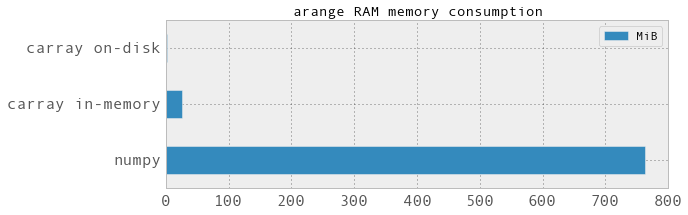

In [8]:
%matplotlib inline
mw.stop_watching_memory()

d = arange_results
print d

arange_results_df = pd.DataFrame({'MiB': arange_results.values()}, index=arange_results.keys())
pd.options.display.mpl_style = 'default'
arange_results_df.plot(kind='barh', figsize=(9,3), fontsize=16, title="arange RAM memory consumption")

In this example, the numpy array consumes aproximately what we would expect ~760MB  (N items x 8bytes x 2^-20 factor MB). Due to the nature of our data set, default compression does already a pretty neat job, and the ammount of memory required by this object is much smaller, around 25MB.

But a carray on-disk consumes only 1.5MB, in this case our data resides on-disk using RAM only to keep references to that object, therefore as you see you can store huge amounts of information while treating them as if they were in-memory, carray on-disk and in-memory support exactly the same set of operations.

Compression ratios will highly depend on your data set, in case your data set would be highly random and you could not get good compression ratios, you could always use carray on disk to use as much less RAM as possible.

<a id='Profiling carray iterators'></a>
## Profiling carray iterators
<a href='#go to index'>Go to index</a>

Let's havea a look now at some operations we already saw in this tutorial and check how much memory they actually consume.

In [9]:
sumif_results = {}
mw.start_watching_memory()

In [9] used 14.395 MiB RAM in 0.368s, peaked 0.000 MiB above current, total RAM usage 861.422 MiB


In [10]:
r = sum(v for v in a if v < 10)

In [10] used 0.020 MiB RAM in 21.173s, peaked 0.000 MiB above current, total RAM usage 861.441 MiB


In [11]:
# Get some measurements from the last executed cell:
sumif_results['numpy'] = mw.measurements.memory_delta

In [11] used 0.000 MiB RAM in 0.001s, peaked 0.000 MiB above current, total RAM usage 861.441 MiB


In [12]:
r =  sum(v for v in b if v < 10)

In [12] used 3.105 MiB RAM in 6.884s, peaked 0.000 MiB above current, total RAM usage 864.547 MiB


In [13]:
# Get some measurements from the last executed cell:
sumif_results['carray in-memory'] = mw.measurements.memory_delta

In [13] used 0.004 MiB RAM in 0.001s, peaked 0.000 MiB above current, total RAM usage 864.551 MiB


In [14]:
r =  sum(v for v in b_disk if v < 10)

In [14] used 0.094 MiB RAM in 6.590s, peaked 0.000 MiB above current, total RAM usage 864.645 MiB


In [15]:
# Get some measurements from the last executed cell:
sumif_results['carray on-disk'] = mw.measurements.memory_delta

In [15] used 0.020 MiB RAM in 0.001s, peaked 0.000 MiB above current, total RAM usage 864.664 MiB


{'numpy': 0.01953125, 'carray in-memory': 3.10546875, 'carray on-disk': 0.09375}


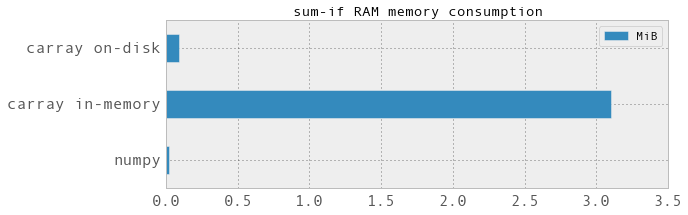

In [16]:
%matplotlib inline
mw.stop_watching_memory()
d = sumif_results
print d

sumif_df = pd.DataFrame({'MiB': d.values()}, index=d.keys())
pd.options.display.mpl_style = 'default'
sumif_df.plot(kind='barh', figsize=(9,3), fontsize=16, title="sum-if RAM memory consumption")

When you iterate `carray` objects, the iterator needs to decompress 
chunks and therefore they use extra memory, but as you can see the 
do that in a very efficient way.
They don't even consume 4MB for iterating a 760MB dataset.

`Numpy` consumes barely no extra memory, but keep in mind that the 
`numpy array` is living raw in-memory, so let's plot these extra 
memory consumptions next to the actual size of the data set.

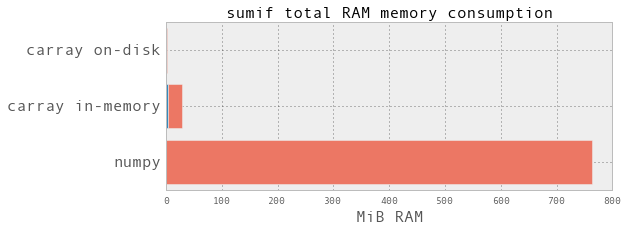

In [18]:
import matplotlib.pyplot as plt
y_pos = np.arange(len(sumif_df))
plt.figure(1, figsize=[8,3])
plt.grid(True)
plt.barh(y_pos, sumif_df.values, align='center')
plt.barh(y_pos, arange_results_df.values,
         left=sumif_df.values,
         align='center', color = '#ec7764')
plt.yticks(y_pos, sumif_df.index, fontsize=16)
plt.xlabel('MiB RAM', fontsize=16)
plt.title('sumif total RAM memory consumption', fontsize=16)